In [434]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score, KFold
import itertools
from xgbtune import tune_xgb_model

import warnings
warnings.filterwarnings("ignore")

In [435]:
#import dataset
btc_df = pd.read_csv(r'sentiment_btc_v2.csv', index_col=0)
eth_df = pd.read_csv(r'sentiment_eth_v2.csv', index_col=0)
price_df = pd.read_csv(r'Prices.csv', index_col=0)
btc_tweet_volume = pd.read_csv(r'BTC_tweet_perday.csv', index_col=0, names=['Date','tweet_volume'], header=0)
eth_tweet_volume = pd.read_csv(r'ETH_tweet_perday.csv', index_col=0, names=['Date','tweet_volume'], header=0)

## Pre-Processing

In [436]:
#set date as Index
price_df = price_df['2020-01-01 00:00:00':'2021-02-03 00:00:00']
price_df.index = pd.to_datetime(price_df.index, utc=True)
price_df = price_df.sort_values(by='Date')
price_df.index = price_df.index.date
price_df.index.name = 'Date'

In [437]:
def PreProc(df, volume_df, price_df=price_df):
    #df
    #set date as Index
    df['Date'] = pd.to_datetime(df['Date'], utc=False)
    df = df.set_index('Date')

    #prep df
    df = df.drop(columns='Tweet', axis=0)
    df = df.sort_values('Date')

    #formatting Index
    df.index = df.index.date
    df.index.name = 'Date'

    #create new features: Impact, classes
    df['Impact'] = 2*df['Retweet']*df['classes'] + df['Likes']*df['classes']
    df = pd.get_dummies(df, columns=['classes'])

    #volume_df
    #set date as Index
    volume_df['Date'] = pd.to_datetime(volume_df['Date'], utc=False)
    volume_df = volume_df.set_index('Date')

    #subsetting df
    volume_df = volume_df['2020-01-01 00:00:00':'2021-02-03 00:00:00']

    #formatting Index
    volume_df.index = volume_df.index.date
    volume_df.index.name = 'Date'

    #Handling missing value
    volume_df[volume_df.isnull()].sum()
    volume_df = volume_df.fillna(method='ffill')

    #merge all df
    merge_df = df.groupby('Date')[['Impact', 'classes_-1', 'classes_1']].sum()
    temp = df.groupby('Date')[['roberta_neg', 'roberta_neu', 'roberta_pos']].mean()
    merge_df = merge_df.merge(temp, on='Date')
    merge_df = pd.merge(merge_df, volume_df, on='Date')
    merge_df = pd.merge(merge_df, price_df, on='Date')
    
    #merge_df['DateTime'] = merge_df.index

    return merge_df

In [438]:
def correlation_heatmap(df):
    _ , ax = plt.subplots(figsize =(14, 12))
    colormap = sns.diverging_palette(220, 10, as_cmap = True)
    
    _ = sns.heatmap(
        df.corr(), 
        cmap = colormap,
        square=True, 
        cbar_kws={'shrink':.9 }, 
        ax=ax,
        annot=True, 
        linewidths=0.1,vmax=1.0, linecolor='white',
        annot_kws={'fontsize':12 }
    )
    
    plt.title('Pearson Correlation of Features', y=1.05, size=15)

In [439]:
def split_plot(train, test, crypto):
    fig, ax = plt.subplots(figsize=(17, 8))
    train[f'{crypto}_close'].plot(ax=ax, label='Training Set')
    test[f'{crypto}_close'].plot(ax=ax, label='Test Set')
    ax.axvline('2020-04-30', color='black', ls='--')
    ax.axvline('2020-05-01', color='black', ls='--')
    plt.legend()
    plt.title(crypto)
    plt.show()

In [440]:
def plot_confusion_matrix(cm, classes, 
                            normalize=False, 
                            title='Confusion matrix', 
                            cmap=plt.cm.Blues):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
            horizontalalignment="center",
            color="black" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [441]:
def Evaluation(model, X_train, y_train, X_test, y_test):
    pred = model.predict(X_train)
    yhat = model.predict(X_test)
    print(classification_report(y_test, yhat))
    print("_______________________________________________")

    train_score = accuracy_score(y_train, pred) * 100
    test_score = accuracy_score(y_test, yhat) * 100

    print(f"Train accuracy Score: {train_score}%")
    print(f"Test accuracy Score: {test_score}%")

    cnf = confusion_matrix(y_test, yhat, labels=[1,0])
    plt.figure()
    plot_confusion_matrix(cnf,classes=['output =1', 'output=0'],normalize = False, title='Confusion matrix')

    return  train_score, test_score, cnf

In [442]:
def model(x_train, y_train, x_test, y_test):
    params = {'eval_metric': 'rmse'}
    params, round_count = tune_xgb_model(params,x_train, y_train)

    classifier=xgb.XGBClassifier(**params)
    classifier=xgb.XGBClassifier()
    
    classifier.fit(x_train, y_train)
    
    predictions = classifier.predict(x_test)

    scores = cross_val_score(classifier, x_train, y_train, cv=5)
    print("Mean cross-validation score: %.2f" % scores.mean())

    kfold = KFold(n_splits=10, shuffle=True)
    kf_cv_scores = cross_val_score(classifier, x_train, y_train, cv=kfold )
    print("K-fold CV average score: %.2f" % kf_cv_scores.mean())

    x, y, cnf = Evaluation(classifier, x_train, y_train, x_test, y_test)

    results_df = pd.DataFrame(data=[["XGBoost", x, y]], 
                            columns=['Model', 'Training Accuracy %', 'Testing Accuracy %'])

### BTC

In [443]:
btc_merge = PreProc(btc_df, btc_tweet_volume)
btc_merge = btc_merge.iloc[:, [0, 1, 2, 3, 4, 5, 6, 7, 9, 11, 13]]
btc_merge.head()

,Impact,classes_-1,classes_1,roberta_neg,roberta_neu,roberta_pos,tweet_volume,+1D BTC,Price Diff BTC,BTC Volume,BTC_close
Date,,,,,,,,,,,
2020-01-01,14142,11.0,41.0,0.147609,0.389144,0.463247,13987.0,0,-214.704392,1.856566e+10,7200.174393
2020-01-02,14141,13.0,34.0,0.186697,0.424369,0.388934,15920.0,1,359.414183,2.080208e+10,6985.470001
2020-01-03,25399,15.0,50.0,0.154831,0.389011,0.456158,19730.0,1,65.772383,2.811148e+10,7344.884183
2020-01-04,9496,11.0,24.0,0.190174,0.434918,0.374908,16357.0,1,0.660760,1.844427e+10,7410.656566
2020-01-05,18747,16.0,27.0,0.207472,0.442393,0.350135,16533.0,1,357.901712,1.972507e+10,7411.317327


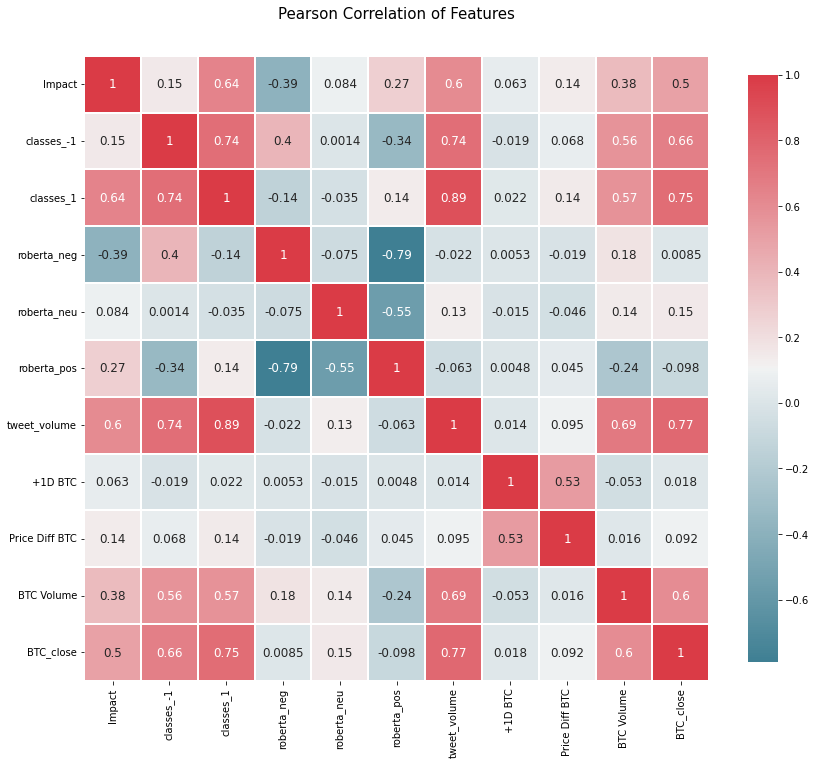

In [444]:
correlation_heatmap(btc_merge)

### ETH

In [445]:
eth_merge = PreProc(eth_df, eth_tweet_volume)
eth_merge = eth_merge.iloc[:, [0, 1, 2, 3, 4, 5, 6, 8, 10, 12, 14]]
eth_merge.head()

,Impact,classes_-1,classes_1,roberta_neg,roberta_neu,roberta_pos,tweet_volume,+1D ETH,Price Diff ETH,ETH Volume,ETH_close
Date,,,,,,,,,,,
2020-01-01,4255,6,14,0.176346,0.398649,0.425005,13987.0,0,-3.391826,7.935230e+09,130.802008
2020-01-02,9203,4,21,0.143010,0.362089,0.494901,15920.0,1,6.761530,8.032709e+09,127.410182
2020-01-03,1228,12,15,0.241671,0.439932,0.318397,19730.0,1,0.897659,1.047685e+10,134.171712
2020-01-04,5093,1,14,0.108702,0.456677,0.434621,16357.0,1,1.207405,7.430905e+09,135.069371
2020-01-05,6856,6,11,0.204835,0.423434,0.371731,16533.0,1,8.027377,7.526675e+09,136.276777


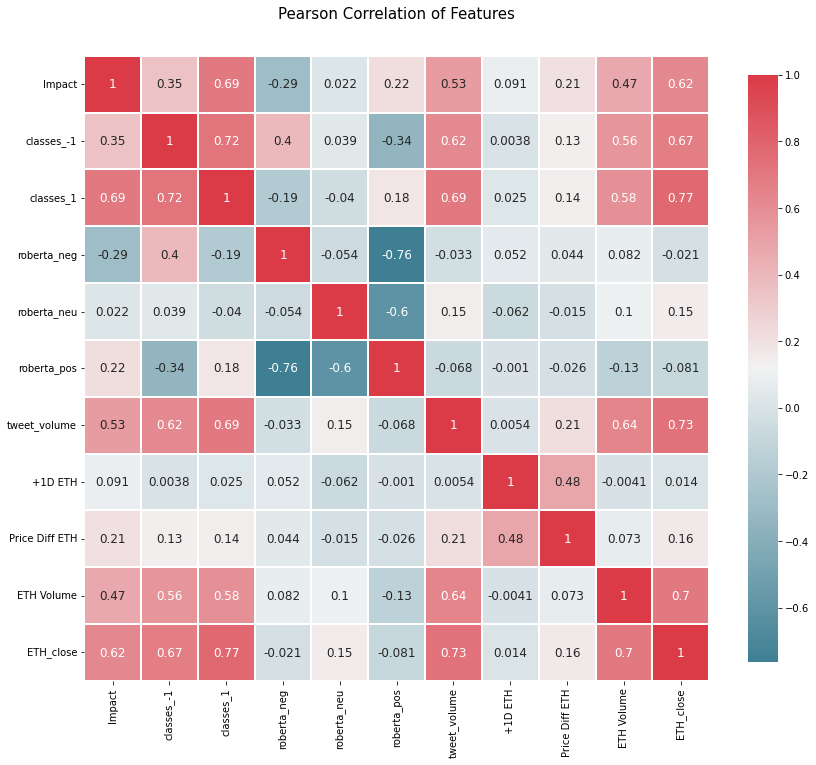

In [446]:
correlation_heatmap(eth_merge)

## Train-Test-Split

In [447]:
#date1 = pd.to_datetime('2020-07-30').date()
#date2 = pd.to_datetime('2020-08-01').date()

date1 = pd.to_datetime('2020-12-30').date()
date2 = pd.to_datetime('2021-01-01').date()

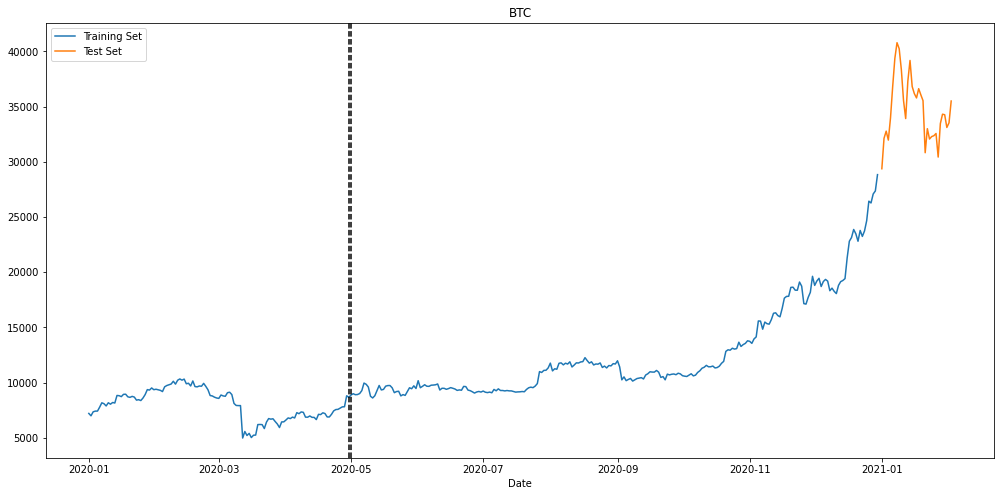

In [448]:
train_btc = btc_merge[:date1]
test_btc = btc_merge[date2:]
split_plot(train_btc, test_btc, 'BTC')
#test_btc = btc_merge

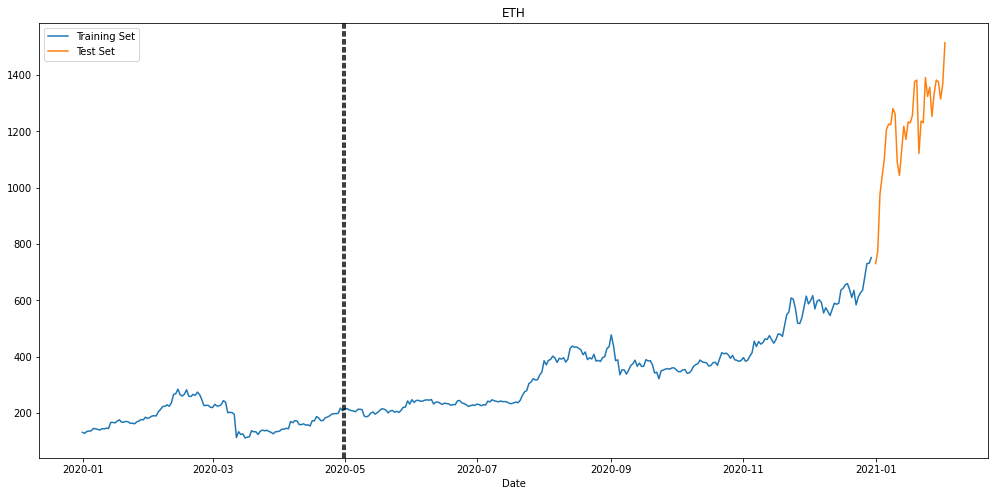

In [449]:
train_eth = eth_merge[:date1]
test_eth = eth_merge[date2:]
split_plot(train_eth, test_eth, 'ETH')
#test_eth = eth_merge

## Model

In [450]:
train_btc.columns

Index(['Impact', 'classes_-1', 'classes_1', 'roberta_neg', 'roberta_neu',
       'roberta_pos', 'tweet_volume', '+1D BTC', 'Price Diff BTC',
       'BTC Volume', 'BTC_close'],
      dtype='object')

In [451]:
x_train_btc = train_btc.drop(['Impact','BTC_close', 'Price Diff BTC', '+1D BTC', 'BTC Volume'], axis=1) 
y_train_btc = train_btc['+1D BTC']
x_test_btc = test_btc.drop(['Impact','BTC_close', 'Price Diff BTC', '+1D BTC', 'BTC Volume'], axis=1) 
y_test_btc = test_btc['+1D BTC']

x_train_eth = train_eth.drop(['ETH_close', 'Price Diff ETH', '+1D ETH', 'ETH Volume'], axis=1) 
y_train_eth = train_eth['+1D ETH']
x_test_eth = test_eth.drop(['ETH_close', 'Price Diff ETH', '+1D ETH', 'ETH Volume'], axis=1) 
y_test_eth = test_eth['+1D ETH']

### Klasifikasi

tuning pass 0...
computing best round...
best round: 1
tuning max_depth and min_child_weight ...
best loss: 0.429
best max_depth: 8
best min_child_weight: 1
tuning gamma ...
best loss: 0.429
best gamma: 0.0
re-computing best round...
best round: 1
tuning subsample and colsample_bytree ...
best loss: 0.4264
best subsample: 0.9
best colsample_bytree: 0.7
fine tuning subsample and colsample_bytree ...
best loss: 0.4264
best subsample: 0.9
best colsample_bytree: 0.7
tuning alpha and lambda ...
best loss: 0.4264
best alpha: 0
best lambda: 1
tuning seed ...
best loss: 0.4247
best seed: 7
{'eval_metric': 'rmse', 'max_depth': 8, 'min_child_weight': 1, 'gamma': 0.0, 'subsample': 0.9, 'colsample_bytree': 0.7, 'alpha': 0, 'lambda': 1, 'seed': 7}
tuning pass 1...
computing best round...
best round: 2
tuning max_depth and min_child_weight ...
best loss: 0.3732
best max_depth: 8
best min_child_weight: 1
tuning gamma ...
best loss: 0.3732
best gamma: 0.0
re-computing best round...
best round: 2
tunin

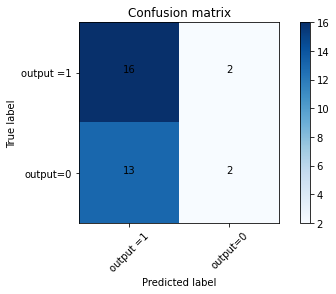

In [452]:
model(x_train_btc, y_train_btc, x_test_btc, y_test_btc)

tuning pass 0...
computing best round...
best round: 1
tuning max_depth and min_child_weight ...
best loss: 0.4174
best max_depth: 8
best min_child_weight: 1
tuning gamma ...
best loss: 0.4174
best gamma: 0.0
re-computing best round...
best round: 1
tuning subsample and colsample_bytree ...
best loss: 0.4174
best subsample: 1.0
best colsample_bytree: 1.0
fine tuning subsample and colsample_bytree ...
best loss: 0.4174
best subsample: 1.0
best colsample_bytree: 1.0
tuning alpha and lambda ...
best loss: 0.4153
best alpha: 0.1
best lambda: 1.5
tuning seed ...
best loss: 0.4153
best seed: 0
{'eval_metric': 'rmse', 'max_depth': 8, 'min_child_weight': 1, 'gamma': 0.0, 'subsample': 1.0, 'colsample_bytree': 1.0, 'alpha': 0.1, 'lambda': 1.5, 'seed': 0}
tuning pass 1...
computing best round...
best round: 1
tuning max_depth and min_child_weight ...
best loss: 0.4153
best max_depth: 8
best min_child_weight: 1
tuning gamma ...
best loss: 0.4153
best gamma: 0.0
re-computing best round...
best roun

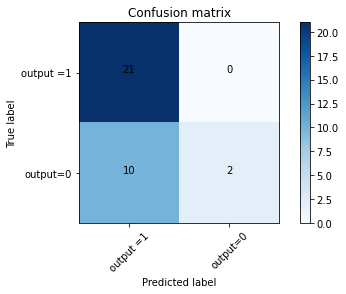

In [454]:
model(x_train_eth, y_train_eth, x_test_eth, y_test_eth)